<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase2/blob/master/EVA4P2_S8_SRGAN_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Sun Oct 11 12:09:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [4]:
import warnings
warnings.filterwarnings('ignore')
import zipfile
from zipfile import ZipFile
from pathlib import Path
from time import time
from datetime import datetime 
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
import torch.utils.data
import torchvision.utils as utils
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import pandas as pd

from tqdm import tqdm
from tqdm import tqdm_notebook
from tqdm.auto import tqdm

from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pkgutil
import importlib
import os
import random
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
import io
import skimage
from skimage.transform import resize
from itertools import groupby
import gc

import seaborn as sns
sns.set()

!pip install torchsummary
from torchsummary import summary

import math
from math import log10

print('Pytorch version:', torch.__version__)

Pytorch version: 1.5.1+cu92


In [5]:
# Copying the code from github to colab
os.chdir('/content/')
!git clone https://github.com/anilbhatt1/Deep_Learning_EVA4_Phase2

fatal: destination path 'Deep_Learning_EVA4_Phase2' already exists and is not an empty directory.


In [6]:
%cd '/content/Deep_Learning_EVA4_Phase2/S8_SRGAN_Neural Transfer'
! ls

/content/Deep_Learning_EVA4_Phase2/S8_SRGAN_Neural Transfer
data_utils.py  model.py     pytorch_ssim  train.py
loss.py        __pycache__  README.md


In [7]:
os.chdir('/content/Deep_Learning_EVA4_Phase2/S8_SRGAN_Neural Transfer/')
import pytorch_ssim
from data_utils import TrainDatasetFromFolder, ValDatasetFromFolder, display_transform
from loss import GeneratorLoss
from model import Generator, Discriminator

In [19]:
CROP_SIZE      = 44
UPSCALE_FACTOR = 4
NUM_EPOCHS     = 500

In [20]:
train_set    = TrainDatasetFromFolder('/content/gdrive/My Drive/EVA4P2_S8_Data/train_data', crop_size=CROP_SIZE, upscale_factor=UPSCALE_FACTOR)
val_set      = ValDatasetFromFolder('/content/gdrive/My Drive/EVA4P2_S8_Data/valid_data', upscale_factor=UPSCALE_FACTOR)
train_loader = DataLoader(dataset=train_set, num_workers=4, batch_size=64, shuffle=True)
val_loader   = DataLoader(dataset=val_set, num_workers=4, batch_size=1, shuffle=False)

In [21]:
netG = Generator(UPSCALE_FACTOR)
print('# generator parameters:', sum(param.numel() for param in netG.parameters()))
netD = Discriminator()
print('# discriminator parameters:', sum(param.numel() for param in netD.parameters()))

# generator parameters: 734219
# discriminator parameters: 5215425


In [22]:
generator_criterion = GeneratorLoss()

In [23]:
if torch.cuda.is_available():
   netG.cuda()
   netD.cuda()
   generator_criterion.cuda()

optimizerG = optim.Adam(netG.parameters())
optimizerD = optim.Adam(netD.parameters())

results = {'d_loss': [], 'g_loss': [], 'd_score': [], 'g_score': [], 'psnr': [], 'ssim': []}

In [24]:
summary(netD, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
       BatchNorm2d-4           [-1, 64, 64, 64]             128
         LeakyReLU-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
       BatchNorm2d-7          [-1, 128, 64, 64]             256
         LeakyReLU-8          [-1, 128, 64, 64]               0
            Conv2d-9          [-1, 128, 32, 32]         147,584
      BatchNorm2d-10          [-1, 128, 32, 32]             256
        LeakyReLU-11          [-1, 128, 32, 32]               0
           Conv2d-12          [-1, 256, 32, 32]         295,168
      BatchNorm2d-13          [-1, 256, 32, 32]             512
        LeakyReLU-14          [-1, 256,

In [25]:
summary(netG, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]          15,616
             PReLU-2         [-1, 64, 128, 128]               1
            Conv2d-3         [-1, 64, 128, 128]          36,928
       BatchNorm2d-4         [-1, 64, 128, 128]             128
             PReLU-5         [-1, 64, 128, 128]               1
            Conv2d-6         [-1, 64, 128, 128]          36,928
       BatchNorm2d-7         [-1, 64, 128, 128]             128
     ResidualBlock-8         [-1, 64, 128, 128]               0
            Conv2d-9         [-1, 64, 128, 128]          36,928
      BatchNorm2d-10         [-1, 64, 128, 128]             128
            PReLU-11         [-1, 64, 128, 128]               1
           Conv2d-12         [-1, 64, 128, 128]          36,928
      BatchNorm2d-13         [-1, 64, 128, 128]             128
    ResidualBlock-14         [-1, 64, 1

In [26]:
netD_prev_save = f'/content/gdrive/My Drive/EVA4P2_S8_Data/Weights_D1011/netD_10_20201011122058.pt'
netD.load_state_dict(torch.load(netD_prev_save))
netG_prev_save = f'/content/gdrive/My Drive/EVA4P2_S8_Data/Weights_D1011/netG_10_20201011122058.pt'
netG.load_state_dict(torch.load(netG_prev_save))

<All keys matched successfully>

In [27]:
    for epoch in range(1, NUM_EPOCHS + 1):

        running_results = {'batch_sizes': 0, 'd_loss': 0, 'g_loss': 0, 'd_score': 0, 'g_score': 0}
        print('epoch',epoch)
    
        netG.train()
        netD.train()
        for data, target in train_loader:    # data is lr image, target is hr image. eg: lr image (64,3,11,11) & hr image (64,3,44,44)
            g_update_first = True
            batch_size = data.size(0)
            running_results['batch_sizes'] += batch_size
    
            ############################
            # (1) Update D network: maximize D(x)-1-D(G(z))
            ###########################
            real_img = Variable(target)   # We are using variable to ensure back-propagation reaches the input hr image
            if torch.cuda.is_available():
                real_img = real_img.cuda()
            z = Variable(data)           # We are using variable to ensure back-propagation reaches the input lr image 
            if torch.cuda.is_available():
                z = z.cuda()
            fake_img = netG(z)          # lr img is the input to generator which will create an sr image
    
            netD.zero_grad()
            real_out = netD(real_img).mean()
            fake_out = netD(fake_img).mean()
            d_loss = 1 - real_out + fake_out
            d_loss.backward(retain_graph=True)
            optimizerD.step()
    
            ############################
            # (2) Update G network: minimize 1-D(G(z)) + Perception Loss + Image Loss + TV Loss
            ###########################
            netG.zero_grad()
            ############################################################
            ## The two lines below are added to prevent runetime error! ##
            fake_img = netG(z)
            fake_out = netD(fake_img).mean()
            ############################################################
            g_loss = generator_criterion(fake_out, fake_img, real_img)    # fake_img will be same size as real_img (i.e. hr_img used for training) eg: (64,3,44,44)
            g_loss.backward()
            
            fake_img = netG(z)
            fake_out = netD(fake_img).mean()
            
            
            optimizerG.step()

            # loss for current batch before optimization 
            running_results['g_loss']  += g_loss.item() * batch_size
            running_results['d_loss']  += d_loss.item() * batch_size
            running_results['d_score'] += real_out.item() * batch_size
            running_results['g_score'] += fake_out.item() * batch_size

        if epoch % 25 == 0:
            loss_d  = running_results['d_loss'] / running_results['batch_sizes']
            loss_g  = running_results['g_loss'] / running_results['batch_sizes']
            d_score = running_results['d_score'] / running_results['batch_sizes']
            g_score = running_results['g_score'] / running_results['batch_sizes']
            print(f'Training ~ Epoch - {epoch}/{NUM_EPOCHS}, Loss_D: {loss_d:.4f}, Loss_G: {loss_g:.4f}, D(x) Score: {d_score:.4f}, D(G(z)) Score: {g_score:.4f}')            
    
        netG.eval()
        out_path     = f'/content/gdrive/My Drive/EVA4P2_S8_Data/Results_D1011/'
        path_name_wt = f'/content/gdrive/My Drive/EVA4P2_S8_Data/Weights_D1011/'
        stat_path = f'/content/gdrive/My Drive/EVA4P2_S8_Data/Statistics/'

        with torch.no_grad():
            valing_results = {'mse': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0, 'batch_sizes': 0}
            val_images = []

            # Image sizes of validation differs from training. Refer TrainDatasetFromFolder class for more details.
            # val_lr -> Low resolution image, val_hr_restore -> Resized version of Low resolution image, val_hr -> Cropped version of original image

            for val_lr, val_hr_restore, val_hr in val_loader:
                batch_size = val_lr.size(0)
                valing_results['batch_sizes'] += batch_size
                lr = val_lr
                hr = val_hr
                if torch.cuda.is_available():
                    lr = lr.cuda()
                    hr = hr.cuda()
                sr = netG(lr)
        
                batch_mse = ((sr - hr) ** 2).data.mean()
                valing_results['mse'] += batch_mse * batch_size
                batch_ssim = pytorch_ssim.ssim(sr, hr).item()
                #batch_ssim = ssim(sr, hr).item()
                valing_results['ssims'] += batch_ssim * batch_size
                valing_results['psnr'] = 10 * log10((hr.max()**2) / (valing_results['mse'] / valing_results['batch_sizes']))
                valing_results['ssim'] = valing_results['ssims'] / valing_results['batch_sizes']
        
                # This is for display, left will be having LR image (hr_restore is a resized version of LR img only)
                #                    middle will be having HR image (this is the original validation image - ground truth)
                #                     right will be having SR image (this is the generated img, our aim is to make this better than GT)
                val_images.extend(
                    [display_transform()(val_hr_restore.squeeze(0)), display_transform()(hr.data.cpu().squeeze(0)),
                     display_transform()(sr.data.cpu().squeeze(0))])
            
            val_images = torch.stack(val_images)                             # Concatenates sequence of tensors. All tensors need to be of the same size. 
                                                                             # eg: If val dataset has 20 images, then [60, 3, 400, 400] i.e. 20 + 20 + 20 = 60
            val_images = torch.chunk(val_images, val_images.size(0) // 15)   # Splits a tensor into a specific number of chunks. 
                                                                             # We are displaying 5 images, 5 rows - each row having LR, HR, SR
            
            if epoch % 25 == 0:
                psnr_val = valing_results['psnr']
                ssim_val = valing_results['ssim']
                print(f'Validation ~ Epoch - {epoch}/{NUM_EPOCHS}, PSNR: {psnr_val:.4f}, SSIM: {ssim_val:.4f}')

                for image in val_images:
                    t = datetime.now()
                    time_stamp = t.strftime("%Y")+t.strftime("%m")+t.strftime("%d")+t.strftime("%H")+t.strftime("%M")+t.strftime("%S")                
                    image = utils.make_grid(image, nrow=3, padding=5)
                    utils.save_image(image, f'{out_path}SRGAN_{epoch}_{time_stamp}.png', padding=5)
    
        results['d_loss'].append(running_results['d_loss'] / running_results['batch_sizes'])
        results['g_loss'].append(running_results['g_loss'] / running_results['batch_sizes'])
        results['d_score'].append(running_results['d_score'] / running_results['batch_sizes'])
        results['g_score'].append(running_results['g_score'] / running_results['batch_sizes'])
        results['psnr'].append(valing_results['psnr'])
        results['ssim'].append(valing_results['ssim'])
    
        if epoch % 50 == 0:
            data_frame = pd.DataFrame(
                data={'Loss_D': results['d_loss'], 'Loss_G': results['g_loss'], 'Score_D': results['d_score'],
                      'Score_G': results['g_score'], 'PSNR': results['psnr'], 'SSIM': results['ssim']})
                #index=range(1, epoch + 1))
            data_frame.to_csv(stat_path + 'srf_' + str(UPSCALE_FACTOR) + '_train_results.csv', index_label='Epoch')

        ### Keep the model in Gpu & Save the model values in intermittent epochs
        if epoch % 50 == 0 or epoch == (NUM_EPOCHS-1):
            t = datetime.now()
            time_stamp = t.strftime("%Y")+t.strftime("%m")+t.strftime("%d")+t.strftime("%H")+t.strftime("%M")+t.strftime("%S")         
            torch.save(netG.state_dict(),f'{path_name_wt}netG_{epoch}_{time_stamp}.pt')
            torch.save(netD.state_dict(),f'{path_name_wt}netD_{epoch}_{time_stamp}.pt')                              
            print(f'GPU models saved in epoch {epoch}/{NUM_EPOCHS}')

        ### Convert the model to CPU & save the model values on final epoch    
        if epoch == (NUM_EPOCHS-1):              
            t = datetime.now()
            time_stamp = t.strftime("%Y")+t.strftime("%m")+t.strftime("%d")+t.strftime("%H")+t.strftime("%M")+t.strftime("%S")
            netG.eval()
            netD.eval()
            netG.to('cpu')
            netD.to('cpu')
            traced_netD = torch.jit.trace(netD,torch.randn(1,3,128,128))      
            traced_netD.save(f'{path_name_wt}netD_CPU_{epoch}_{time_stamp}.pt')
            traced_netG = torch.jit.trace(netG,torch.randn(1,3,128,128))      
            traced_netG.save(f'{path_name_wt}netG_CPU_{epoch}_{time_stamp}.pt')             
            print(f' **** CPU models Saved in epoch:{epoch+1}/{NUM_EPOCHS}')
            netG.cuda()
            netD.cuda()     

epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Training ~ Epoch - 25/500, Loss_D: 1.0111, Loss_G: 0.0058, D(x) Score: 0.7490, D(G(z)) Score: 0.7594
Validation ~ Epoch - 25/500, PSNR: 24.1977, SSIM: 0.8041
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
Training ~ Epoch - 50/500, Loss_D: 1.0136, Loss_G: 0.0054, D(x) Score: 0.7823, D(G(z)) Score: 0.7933
Validation ~ Epoch - 50/500, PSNR: 25.0997, SSIM: 0.8168
GPU models saved in epoch 50/500
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epo

In [28]:
print(len(results['d_loss']), len(results['g_loss']), len(results['d_score']), len(results['g_score']), len(results['psnr']), len(results['ssim']))

500 500 500 500 500 500


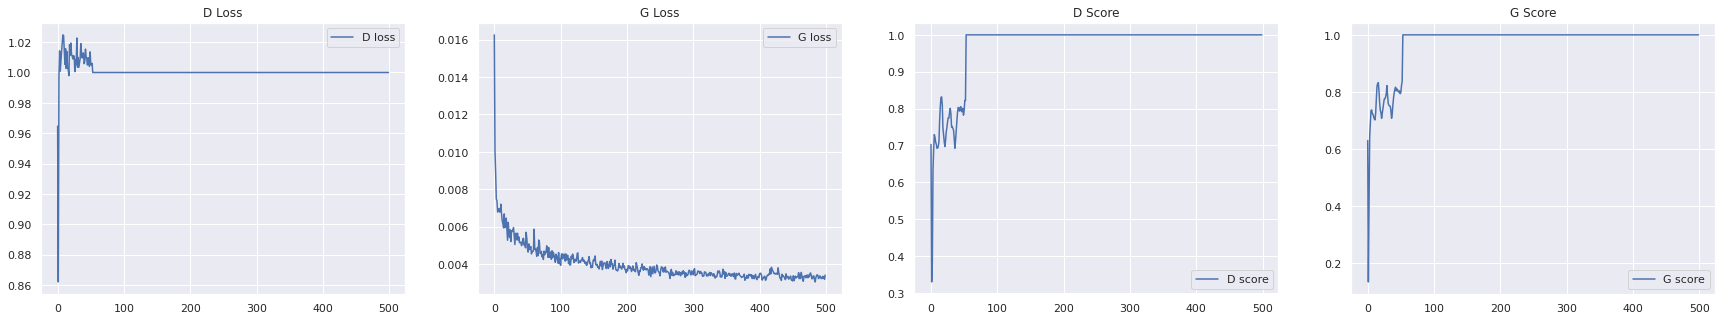

In [29]:
figure = plt.figure(figsize=(30,5))
labels = ['Loss Plots']

plt.subplot(1,4,1)
plt.title("D Loss")
plt.plot(results['d_loss'],label='D loss')
plt.legend(loc="best")

plt.subplot(1,4,2)
plt.title("G Loss")
plt.plot(results['g_loss'],label='G loss')
plt.legend(loc="best")

plt.subplot(1,4,3)
plt.title("D Score")
plt.plot(results['d_score'],label='D score')
plt.legend(loc="best")

plt.subplot(1,4,4)
plt.title("G Score")
plt.plot(results['g_score'],label='G score')
plt.legend(loc="best")

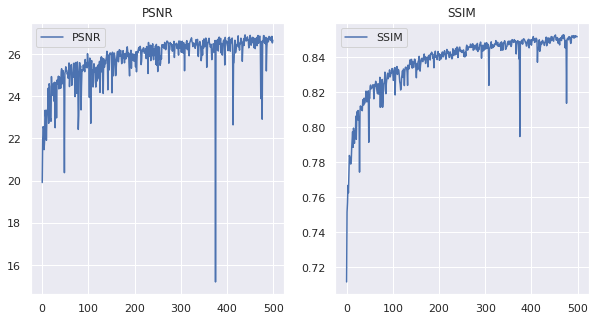

In [30]:
figure = plt.figure(figsize=(10,5))
labels = ['PSNR & SSIM Plots']

plt.subplot(1,2,1)
plt.title("PSNR")
plt.plot(results['psnr'],label='PSNR')
plt.legend(loc="best")

plt.subplot(1,2,2)
plt.title("SSIM")
plt.plot(results['ssim'],label='SSIM')
plt.legend(loc="best")